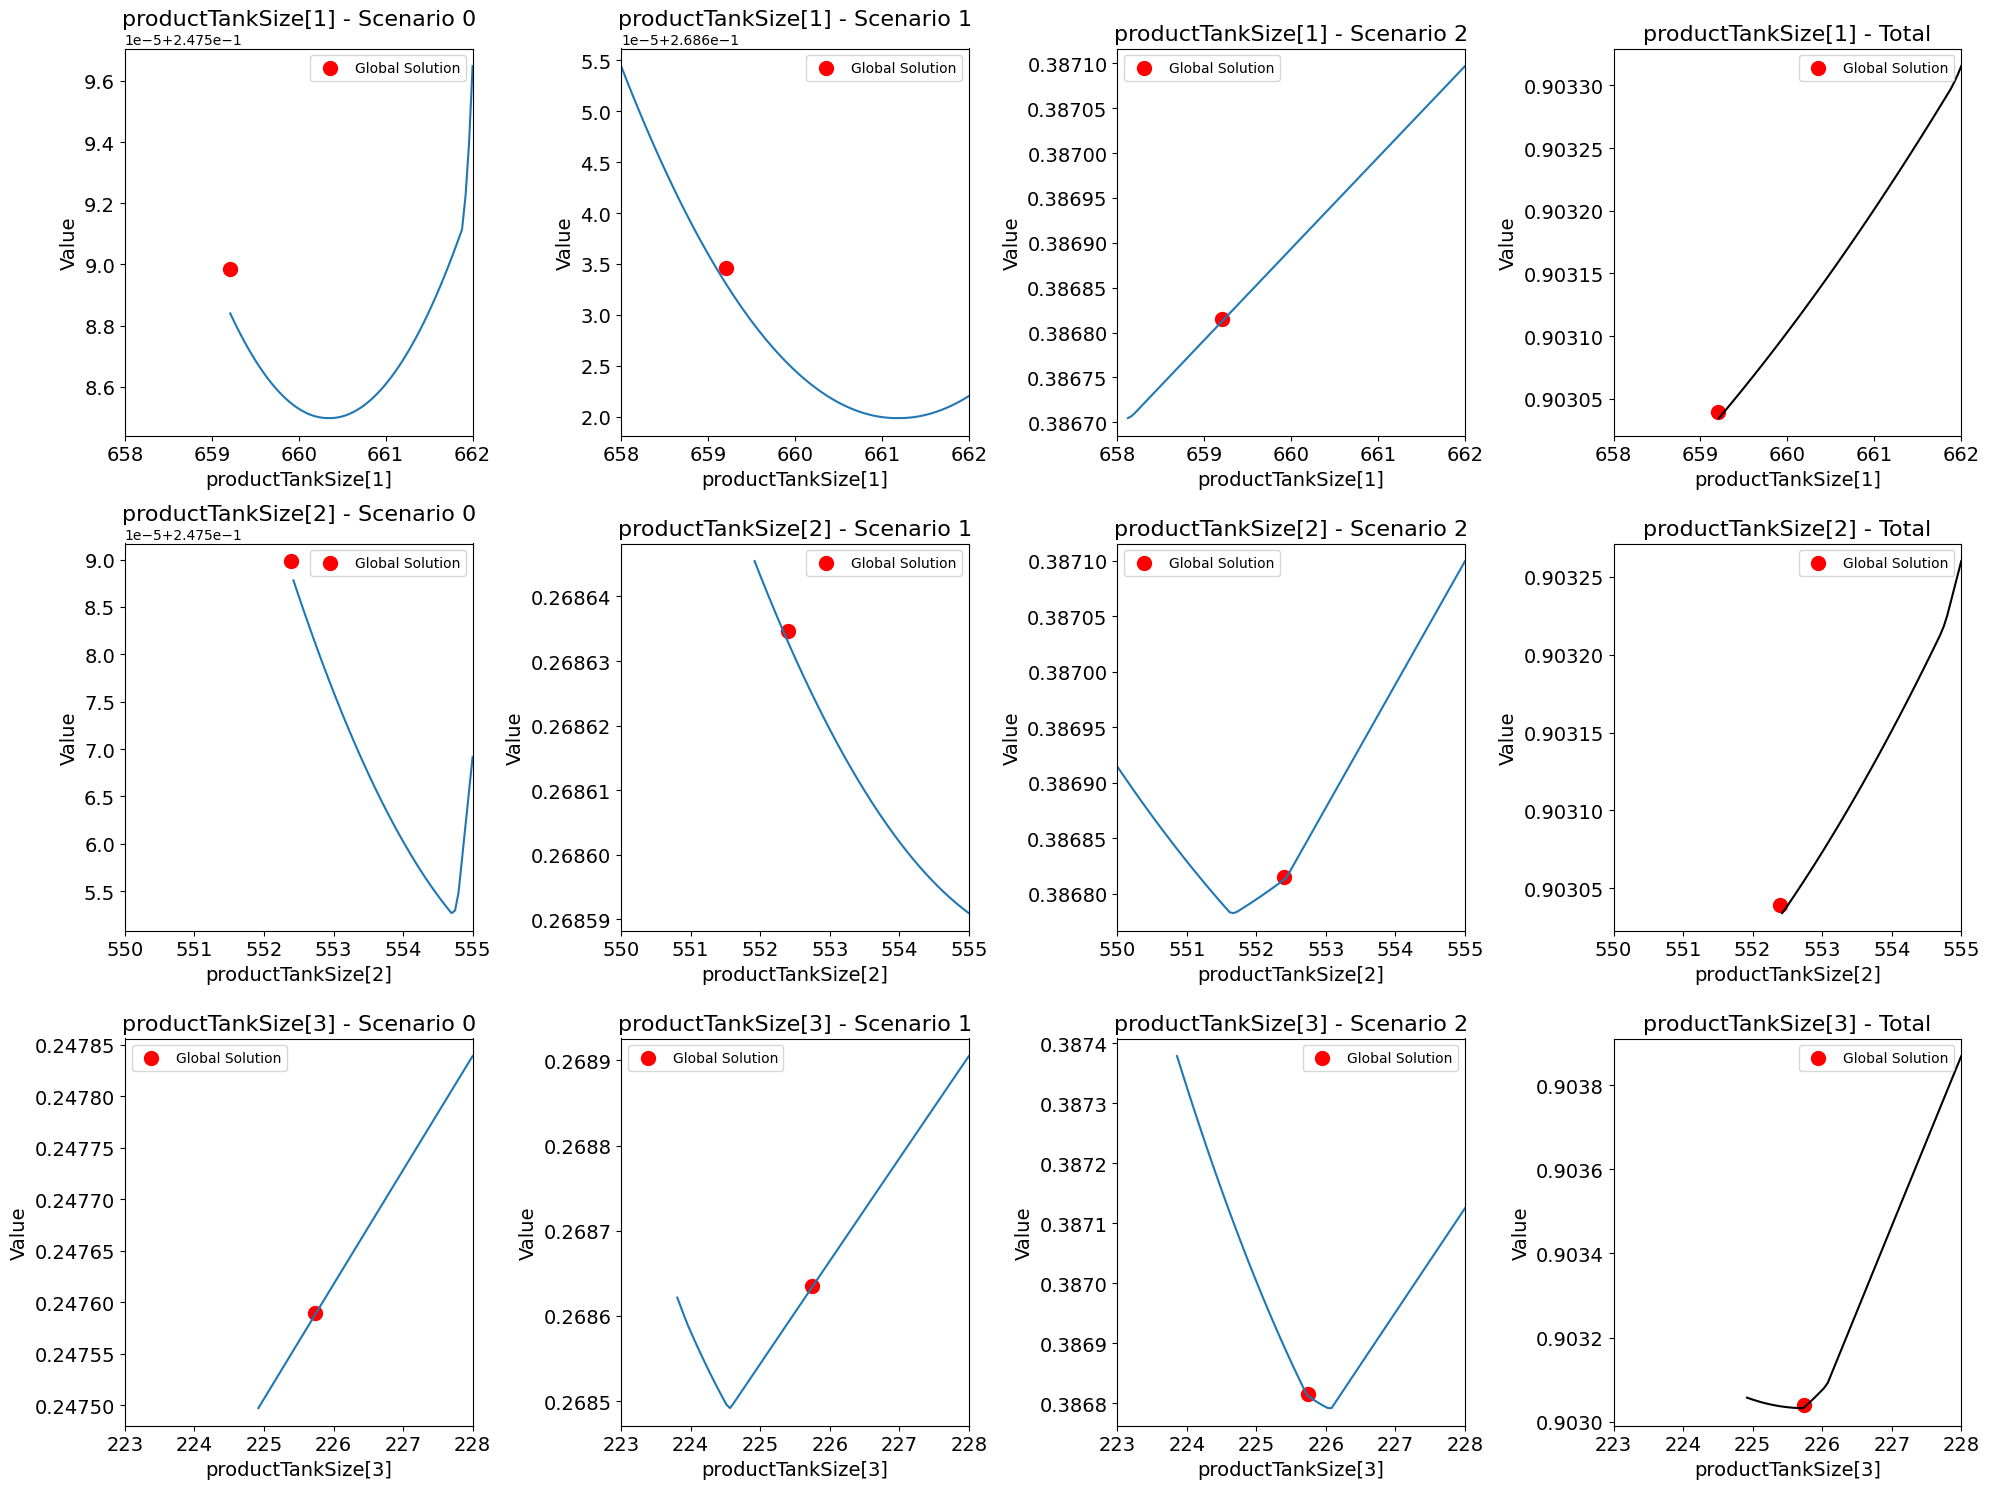

({'productTankSize[1]': {0: array([       nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
                 nan,        nan,        nan,        nan,        nan,
          0.2475884 , 0.24758815, 0.24758792, 0.2475877 , 0.24758748,
          0.24758727, 0.24758708, 0.24758689, 0.24758671, 0.24758654,
          0.24758638, 0.24758622, 0.24758608, 0.24758594, 0.24758582,
          0.2475857 , 0.24758559, 0.24758549, 0.2475854 , 0.24758532,
          0.24758524, 0.24758518, 0.24758512, 0.24758508, 0.24758504,
          0.24758501, 0.24758499, 0.24758498, 0.24758497, 0.24758498,
          0.24758499, 0.247585  , 0.24758503, 0.24758507, 0.24758511,
          0.24758517, 0.24758523, 0.2475853 , 0.24758538, 0.24758

In [1]:
from src.models.cz_model import CaoZavalaModel, CaoZavalaAlgo
from NSPLIB.src.instances.tanksize.tanksize import const_model
from graphing.value_function.plotting import plotting
# Constants
tanksize_obj = 0.9030394623070541
tanksize_sol = {"productTankSize[1]": 659.2053849850757, "productTankSize[2]": 552.3954188143167, "productTankSize[3]": 225.73997707963284}
tanksize_y_bound = {"productTankSize[1]": [658, 662], "productTankSize[2]": [550, 555], "productTankSize[3]": [223, 228]}

# Build model
sto_m = const_model()
m = CaoZavalaModel.from_sto_m(sto_m)
m.build()
y_dimension = {
    'productTankSize[1]': {}, 'productTankSize[2]': {}, 'productTankSize[3]': {}
}
plotting(m, 100, y_dimension, tanksize_sol, tanksize_y_bound, tanksize_obj)